In [21]:
import os
import re
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.externals import joblib
import matplotlib.pyplot as plt

In [3]:
df_full = pd.read_csv('Consumer_Complaints.csv')
df = df_full.dropna(subset = ["Consumer complaint narrative"])[["Product", "Consumer complaint narrative"]]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231441 entries, 0 to 231440
Data columns (total 2 columns):
Product                         231441 non-null object
Consumer complaint narrative    231441 non-null object
dtypes: object(2)
memory usage: 3.5+ MB


In [4]:
df.Product.value_counts()

Debt collection                                                                 53600
Mortgage                                                                        39452
Credit reporting                                                                31592
Credit reporting, credit repair services, or other personal consumer reports    29805
Credit card                                                                     18842
Bank account or service                                                         14888
Student loan                                                                    14687
Consumer Loan                                                                    9472
Credit card or prepaid card                                                      6197
Checking or savings account                                                      3836
Payday loan                                                                      1748
Vehicle loan or lease                                 

In [5]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

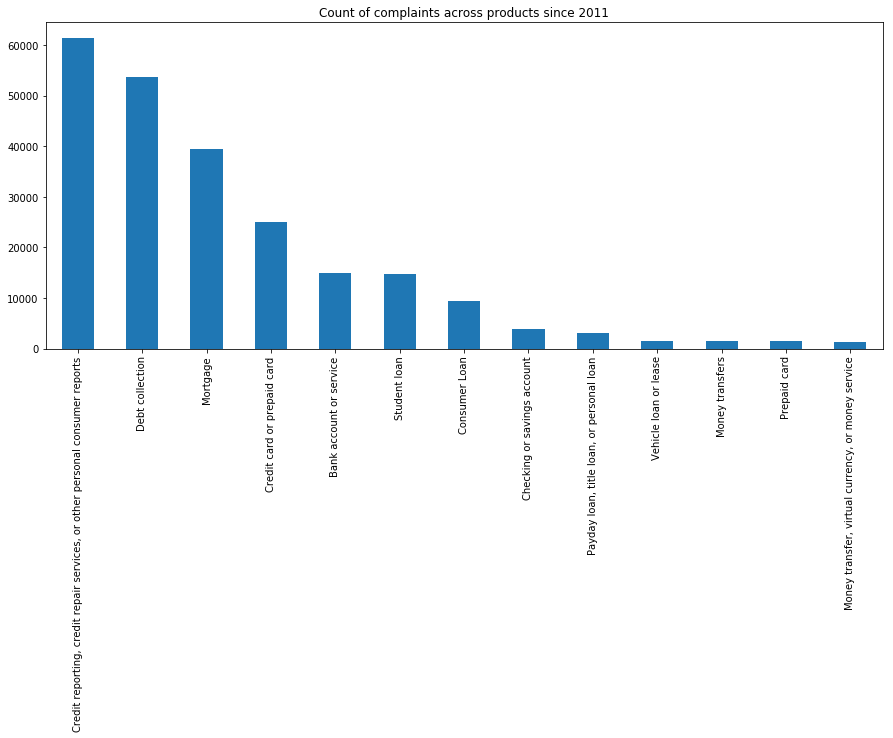

In [8]:
df["Product"].value_counts().plot(x='Product', y='Number of complaints', kind='bar', figsize=(15,6),\
                                  title='Count of complaints across products since 2011')

In [14]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. 
                                              # substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. 
                                        # substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [16]:
complaint=df['Consumer complaint narrative']
product=df['Product']
complaint_train, complaint_test, product_train, product_test = \
train_test_split(complaint, product, test_size=0.1, random_state=42)

In [18]:
print(complaint_train.shape, product_train.shape)
print(complaint_test.shape, product_test.shape)

(208033,) (208033,)
(23115,) (23115,)


In [19]:
logistic_regression = Pipeline([
    ('bow', CountVectorizer(stop_words = STOPWORDS)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression())])

start = time.time()
logistic_regression.fit(complaint_train, product_train)
end = time.time()
print ("Time in training: "+str(end - start))

start = time.time()
predictions=logistic_regression.predict(complaint_test)
end = time.time()
print ("Time in testing: "+str(end - start))

print (classification_report(product_test, predictions))
print (confusion_matrix(product_test, predictions))

/home/wenbo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wenbo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Time in training: 99.61462569236755
Time in testing: 1.1935794353485107
                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.67      0.76      0.71      1496
                                                 Checking or savings account       0.53      0.05      0.09       408
                                                               Consumer Loan       0.66      0.55      0.60       977
                                                 Credit card or prepaid card       0.77      0.83      0.80      2428
Credit reporting, credit repair services, or other personal consumer reports       0.87      0.87      0.87      6141
                                                             Debt collection       0.82      0.88      0.85      5388
                          Money transfer, virtual currency, or money service       0.93      0.27    

In [24]:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
joblib.dump(logistic_regression, os.path.join(model_dir, 'logistic_regression.pkl')) 

['models/logistic_regression.pkl']

In [13]:
joblib.dump(logistic_regression, './web app/logistic_regression.pkl') 

['./web app/logistic_regression.pkl']